In [3]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as st

from imblearn.over_sampling import ADASYN, SMOTE

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

from matplotlib.ticker import FormatStrFormatter
import os
from collections import Counter
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [4]:
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return round(tn / (tn + fp), 2)

def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return round(tp / (tp + fn), 2)

def harmonic(y_true, y_pred, **kwargs):
    sens = sensitivity(y_true, y_pred)
    spec = specificity(y_true, y_pred)
    return round((2 * sens * spec) / (sens + spec), 2)

In [107]:
le = LabelEncoder()
X_train = pd.read_csv('train.csv').drop(columns=['Площадка', 'p_total_ppg', 'lf_ppg', 'hf_ppg', 'vlf_ppg', 'Натощак'])
y_train = le.fit_transform(X_train.pop('Наличие НУО'))
X_train.loc[X_train["Пол"] == 'Мужчина', "Пол"] = 1
X_train.loc[X_train["Пол"] == 'Женщина', "Пол"] = 2
X_train['ИМТ'] = np.round(X_train['Вес, кг'] / (X_train['Рост, см'] / 100)**2)
X_train.drop(columns='Рост, см', inplace=True)
filt_0 = y_train == 0
filt_1 = y_train == 1
y_train[filt_0] = 1
y_train[filt_1] = 0

X_test = pd.read_csv('test.csv').drop(columns=['Площадка', 'p_total_ppg', 'lf_ppg', 'hf_ppg', 'vlf_ppg', 'Натощак'])
X_test.loc[X_test["Пол"] == 'Мужчина', "Пол"] = 1
X_test.loc[X_test["Пол"] == 'Женщина', "Пол"] = 2
X_test['ИМТ'] = np.round(X_test['Вес, кг'] / (X_test['Рост, см'] / 100)**2)
X_test.drop(columns='Рост, см', inplace=True)
y_test = le.transform(X_test.pop('Наличие НУО'))
filt_0 = y_test == 0
filt_1 = y_test == 1
y_test[filt_0] = 1
y_test[filt_1] = 0

In [86]:
le.classes_

array(['наличие НУО', 'отсутствие НУО'], dtype=object)

In [101]:
filt_0 = y_train == 0
filt_1 = y_train == 1
y_train[filt_0] = 1
y_train[filt_1] = 0

In [106]:
Counter(y_train)

Counter({0: 1945, 1: 626})

In [103]:
y_train[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [6]:
n_comps = range(10)
annotation = ['ИМТ', 'Возраст, лет', 'Вес, кг', 'Пол']
expl_var = []
for n_comp in n_comps:
    pca = PCA(n_components=n_comp)
    pca.fit_transform(X_train.drop(columns=annotation))
    pca.transform(X_test.drop(columns=annotation))
    expl_var.append(pca.explained_variance_ratio_.sum())
expl_var[0] = 0.5443

([<matplotlib.axis.XTick at 0x21d237231f0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11')])

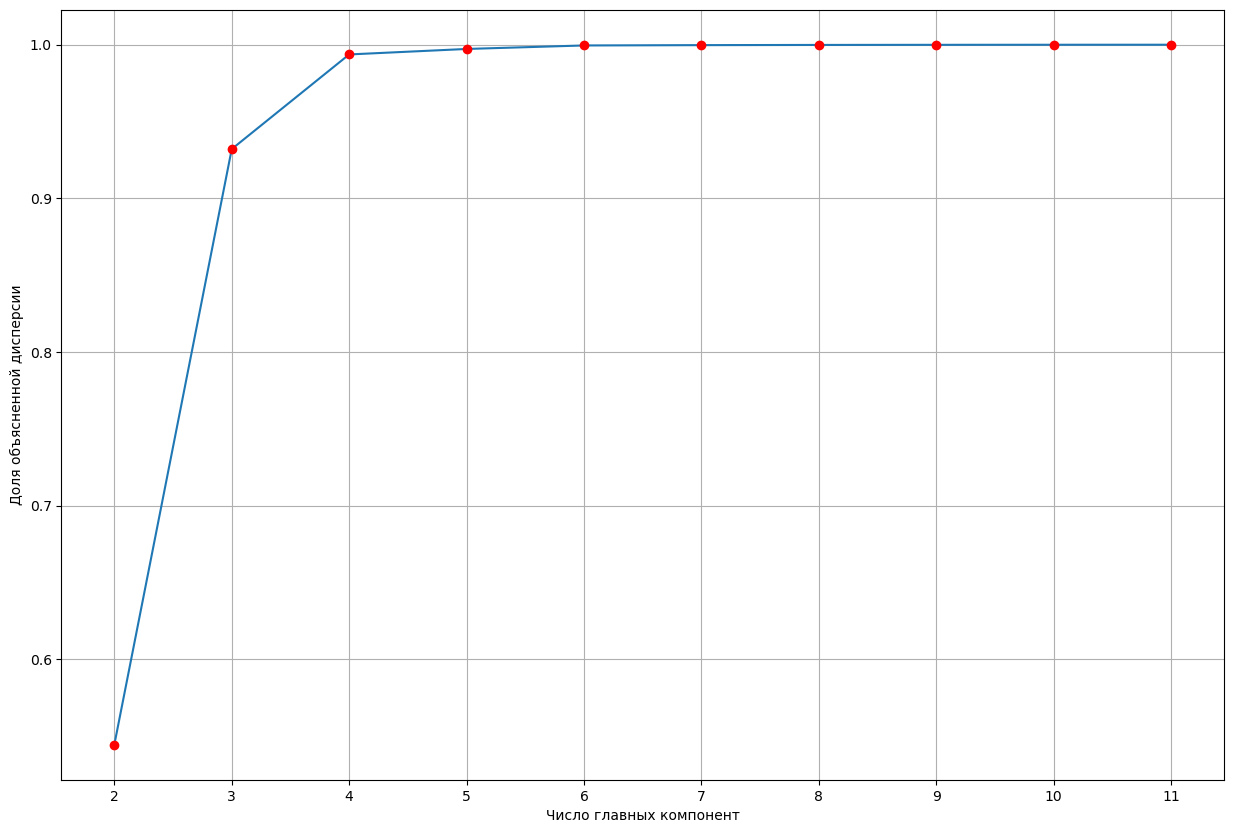

In [7]:
plt.figure(figsize=(15, 10))
plt.xlabel('Число главных компонент')
plt.ylabel('Доля объясненной дисперсии')
plt.plot(np.array(n_comps) + 2, expl_var)
plt.plot(np.array(n_comps) + 2, expl_var, 'o', color='r')
plt.grid()
plt.xticks(np.array(n_comps) + 2)

In [63]:
Counter(y_test)

Counter({1: 251, 0: 67})

In [68]:
tn, fp, fn, tp = confusion_matrix(y_test, initial_preds).ravel()

In [74]:
confusion_matrix(y_test, initial_preds).ravel()

array([ 61,   6, 182,  69], dtype=int64)

In [78]:
model.predict(res_test)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [79]:
model.predict_proba(res_test)[:, 0]

array([0.91, 0.97, 0.97, 0.68, 0.31, 0.9 , 0.98, 0.97, 0.43, 0.87, 0.84,
       0.96, 0.14, 0.63, 0.14, 0.9 , 0.06, 0.42, 0.91, 0.56, 0.6 , 0.33,
       0.42, 0.35, 0.89, 0.77, 0.22, 0.07, 0.75, 0.91, 0.98, 0.92, 0.35,
       0.24, 0.25, 0.15, 0.88, 0.68, 0.83, 0.82, 0.9 , 0.98, 0.53, 0.77,
       0.83, 0.88, 0.97, 0.87, 0.9 , 0.26, 0.5 , 0.76, 0.68, 0.76, 0.78,
       0.49, 0.44, 0.75, 0.87, 0.99, 0.31, 0.11, 0.1 , 0.93, 0.91, 0.95,
       0.78, 0.99, 0.84, 0.93, 0.89, 0.99, 0.92, 0.36, 0.78, 0.96, 0.96,
       0.9 , 0.89, 0.85, 0.92, 0.99, 0.84, 0.88, 0.93, 0.92, 0.96, 0.98,
       0.62, 0.93, 0.86, 0.89, 0.91, 0.6 , 0.74, 0.86, 0.6 , 0.59, 0.58,
       0.92, 0.92, 0.99, 0.9 , 0.88, 0.11, 0.07, 0.51, 0.83, 0.89, 0.74,
       0.95, 0.71, 0.61, 0.48, 0.64, 0.14, 0.08, 0.88, 0.82, 0.88, 0.89,
       0.21, 0.18, 0.58, 0.63, 0.57, 0.64, 0.7 , 0.59, 0.59, 0.92, 0.99,
       0.99, 0.99, 0.96, 0.97, 0.91, 0.88, 0.92, 0.93, 0.64, 0.93, 0.93,
       0.38, 0.86, 0.94, 0.59, 0.99, 0.77, 0.99, 0.

In [67]:
untouchable_test = X_test[annotation]
touchable_test = X_test.drop(columns=annotation)
X_test_selected = selector.transform(touchable_test)
res_test = np.hstack([untouchable_test, X_test_selected])
initial_preds = model.predict(res_test)

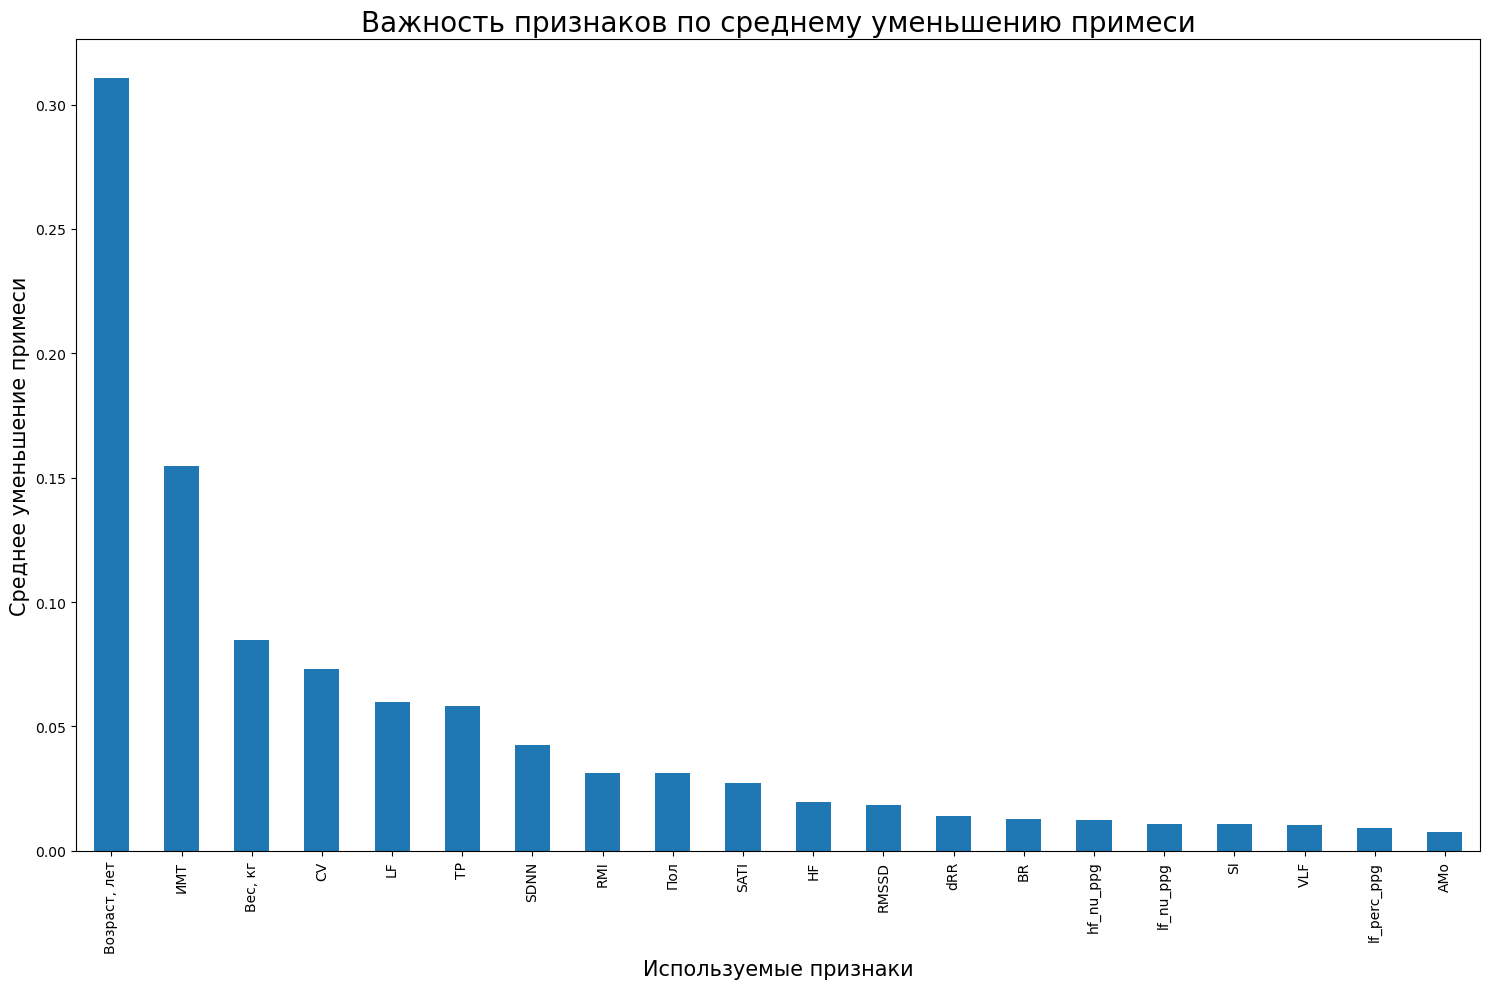

In [65]:
model = RandomForestClassifier()
selector = SelectKBest(k=16)
annotation = ['ИМТ', 'Возраст, лет', 'Вес, кг', 'Пол']
untouchable = X_train[annotation]
touchable = X_train.drop(columns=annotation)
X_train_selected = selector.fit_transform(touchable, y_train)
result = np.hstack([untouchable, X_train_selected])
model.fit(result, y_train)
fig, ax = plt.subplots(figsize=(15, 10))
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=annotation + list(touchable.columns[selector.get_support()])).sort_values(ascending=False)
forest_importances.plot.bar(ax=ax)
ax.set_title("Важность признаков по среднему уменьшению примеси", fontsize=20)
ax.set_ylabel("Среднее уменьшение примеси", fontsize=15)
ax.set_xlabel("Используемые признаки", fontsize=15)
fig.tight_layout()

In [354]:
def get_initial_qulity(model, X_train, y_train, X_test, y_test, header=False):    
    selector = PCA(n_components=4)
    annotation = ['ИМТ', 'Возраст, лет', 'Вес, кг', 'Пол']
    untouchable_train = X_train[annotation]
    touchable_train = X_train.drop(columns=annotation)
    X_train_selected = selector.fit_transform(touchable_train)
    result = np.hstack([untouchable_train, X_train_selected])
    model.fit(result, y_train)
    untouchable_test = X_test[annotation]
    touchable_test = X_test.drop(columns=annotation)
    X_test_selected = selector.fit_transform(touchable_test)
    res_test = np.hstack([untouchable_test, X_test_selected])
    preds = model.predict(res_test)
    pd.DataFrame.from_dict({'sensitivity': [sensitivity(y_test, preds)], 
                            'specificity': [specificity(y_test, preds)], 
                            'roc_auc': [round(roc_auc_score(y_test, model.predict_proba(res_test)[:, 1]), 2)]}).to_csv(f'results/initial_quality.csv', mode='a', index=False, header=header)

In [355]:
for i, model in enumerate([XGBClassifier(), LGBMClassifier(), RandomForestClassifier(random_state=42), AdaBoostClassifier()]):
    if i:
        get_initial_qulity(model, X_train, y_train, X_test, y_test)
    else:
        get_initial_qulity(model, X_train, y_train, X_test, y_test, header=True)

In [356]:
pd.read_csv('results/initial_quality.csv')

,sensitivity,specificity,roc_auc
0,0.31,0.84,0.65
1,0.31,0.79,0.64
2,0.27,0.90,0.66
3,0.31,0.81,0.65


In [108]:
def get_sampling_mx_pca(model, X_train, y_train, X_test, y_test, random_st, n_comp=4):
    samples_dict = {}
    class_count = Counter(y_train).values()
    init_ratio = round(min(class_count) / max(class_count), 1)
    minority_ratio = np.arange(init_ratio + 0.1, 1.1, 0.1)
    
    selector = PCA(n_components=n_comp)
    annotation = ['ИМТ', 'Возраст, лет', 'Вес, кг', 'Пол']
    untouchable_train = X_train[annotation]
    touchable_train = X_train.drop(columns=annotation)
    X_train_selected = selector.fit_transform(touchable_train)
    result = np.hstack([untouchable_train, X_train_selected])
    model.fit(result, y_train)
    untouchable_test = X_test[annotation]
    touchable_test = X_test.drop(columns=annotation)
    X_test_selected = selector.fit_transform(touchable_test)
    res_test = np.hstack([untouchable_test, X_test_selected])
    initial_preds = model.predict(res_test)
    
    sens_res, spec_res, harmonic_res, roc_res = [[] for i in range(4)]
    sens_res.append([sensitivity(y_test, initial_preds)]*len(minority_ratio))
    spec_res.append([specificity(y_test, initial_preds)]*len(minority_ratio))
    harmonic_res.append([harmonic(y_test, initial_preds)]*len(minority_ratio))
    roc_res.append([round(roc_auc_score(y_test, model.predict_proba(res_test)[:, 1]), 2)]*len(minority_ratio))
    for sampling_strategy in [ADASYN, SMOTE]:
        sens_res_temp, spec_res_temp, harmonic_res_temp, roc_res_temp = [[] for i in range(4)]
        for ratio in minority_ratio:
            sampler = sampling_strategy(sampling_strategy=ratio, random_state=random_st)
            X_resampled, y_resampled = sampler.fit_resample(result, y_train)
            samples_dict[f'{re.findall(r"[A-Z]+", str(sampling_strategy))[0]}_{str(ratio)}'] = X_resampled
            model.fit(X_resampled, y_resampled)
            predictions = model.predict(res_test)
            sens_res_temp.append(sensitivity(y_test, predictions))
            spec_res_temp.append(specificity(y_test, predictions))
            harmonic_res_temp.append(harmonic(y_test, predictions))
            roc_res_temp.append(round(roc_auc_score(y_test, model.predict_proba(res_test)[:, 1]), 2))
        sens_res.append(sens_res_temp)
        spec_res.append(spec_res_temp)
        harmonic_res.append(harmonic_res_temp)
        roc_res.append(roc_res_temp)
    return np.array(sens_res), np.array(spec_res), np.array(harmonic_res), np.array(roc_res), samples_dict, annotation + [f'feature_{i+1}' for i in range(n_comp)]

In [109]:
sens_cube, spec_cube, harm_cube, roc_auc_cube = [np.array([]).reshape(-1, 7) for i in range(4)]
class_count = Counter(y_train).values()
init_ratio = round(min(class_count) / max(class_count), 1)
minority_ratio = np.arange(init_ratio + 0.1, 1.1, 0.1)
for model in [XGBClassifier(), LGBMClassifier(), RandomForestClassifier(random_state=42), AdaBoostClassifier()]:
    sens, spec, harm, roc_auc, samples_dict, feature_names = get_sampling_mx_pca(model, X_train, y_train, X_test, y_test, random_st=4)
    sens_cube = np.vstack([sens_cube, sens])
    spec_cube = np.vstack([spec_cube, spec])
    harm_cube = np.vstack([harm_cube, harm])
    roc_auc_cube = np.vstack([roc_auc_cube, roc_auc])
sens_cube = sens_cube.reshape(-1, 3, len(minority_ratio))
spec_cube = spec_cube.reshape(-1, 3, len(minority_ratio))
harm_cube = harm_cube.reshape(-1, 3, len(minority_ratio))
roc_auc_cube = roc_auc_cube.reshape(-1, 3, len(minority_ratio))

In [56]:
def plot_res_for_metric(metric_cube, metric_name, trim_nm=False, models=['XGBoost', 'LightGBM', 'Случайный лес', 'AdaBoost'], samplers=['без сэмплинга', 'ADASYN', 'SMOTE']):
    class_count = Counter(y_train).values()
    init_ratio = round(min(class_count) / max(class_count), 1)
    minority_ratio = np.arange(init_ratio + 0.1, 1.1, 0.1)
    fig, axs = plt.subplots(2, 2, figsize=(15, 13))
    fig.suptitle(metric_name, fontsize=20)
    fig.tight_layout(pad=5.0)
    for i, res_mx in enumerate(metric_cube):
        axs[i // 2, i % 2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[i // 2, i % 2].set_yticks(np.arange(np.round(np.min(res_mx), 2), np.round(np.max(res_mx), 2) + 0.2, 0.01))
        axs[i // 2, i % 2].grid(which='both')
        for j, strategy in enumerate(samplers):
            if strategy == 'без сэмплинга':
                continue
            axs[i // 2, i % 2].plot(minority_ratio, res_mx[j, :], 'o', color='r')
            axs[i // 2, i % 2].plot(minority_ratio, res_mx[j, :], label= strategy)
        axs[i // 2, i % 2].plot(minority_ratio, res_mx[0, :], '--', color='purple', label='без сэмплинга, соотношение классов = 0.3', linewidth=2)
        if trim_nm:
            axs[i // 2, i % 2].set_ylabel('F мера', fontsize=15)
        else:
            axs[i // 2, i % 2].set_ylabel(metric_name, fontsize=15)
        axs[i // 2, i % 2].set_xlabel('Соотношение классов', fontsize=15)
        axs[i // 2, i % 2].set_xticks(minority_ratio)
        axs[i // 2, i % 2].set_title(models[i], fontsize=15)
        axs[i // 2, i % 2].legend()


## Sensitivity

In [113]:
Counter(y_test)

Counter({0: 251, 1: 67})

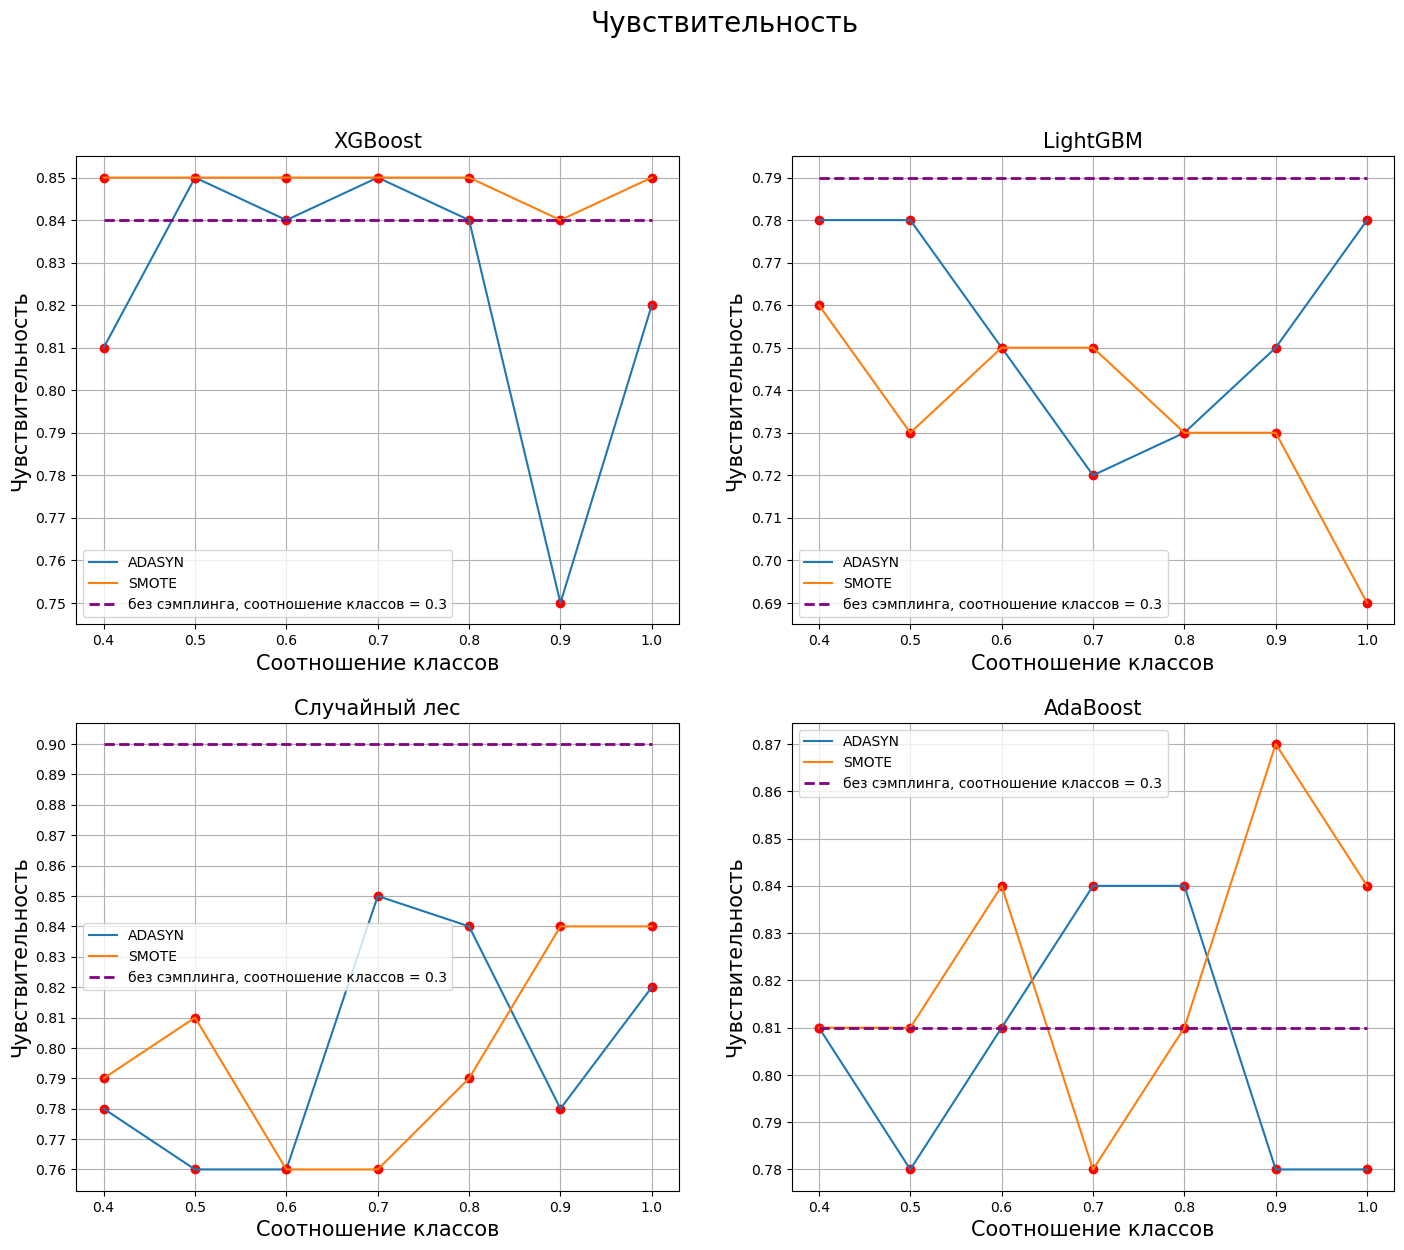

In [110]:
plot_res_for_metric(sens_cube, 'Чувствительность')

## Specificity

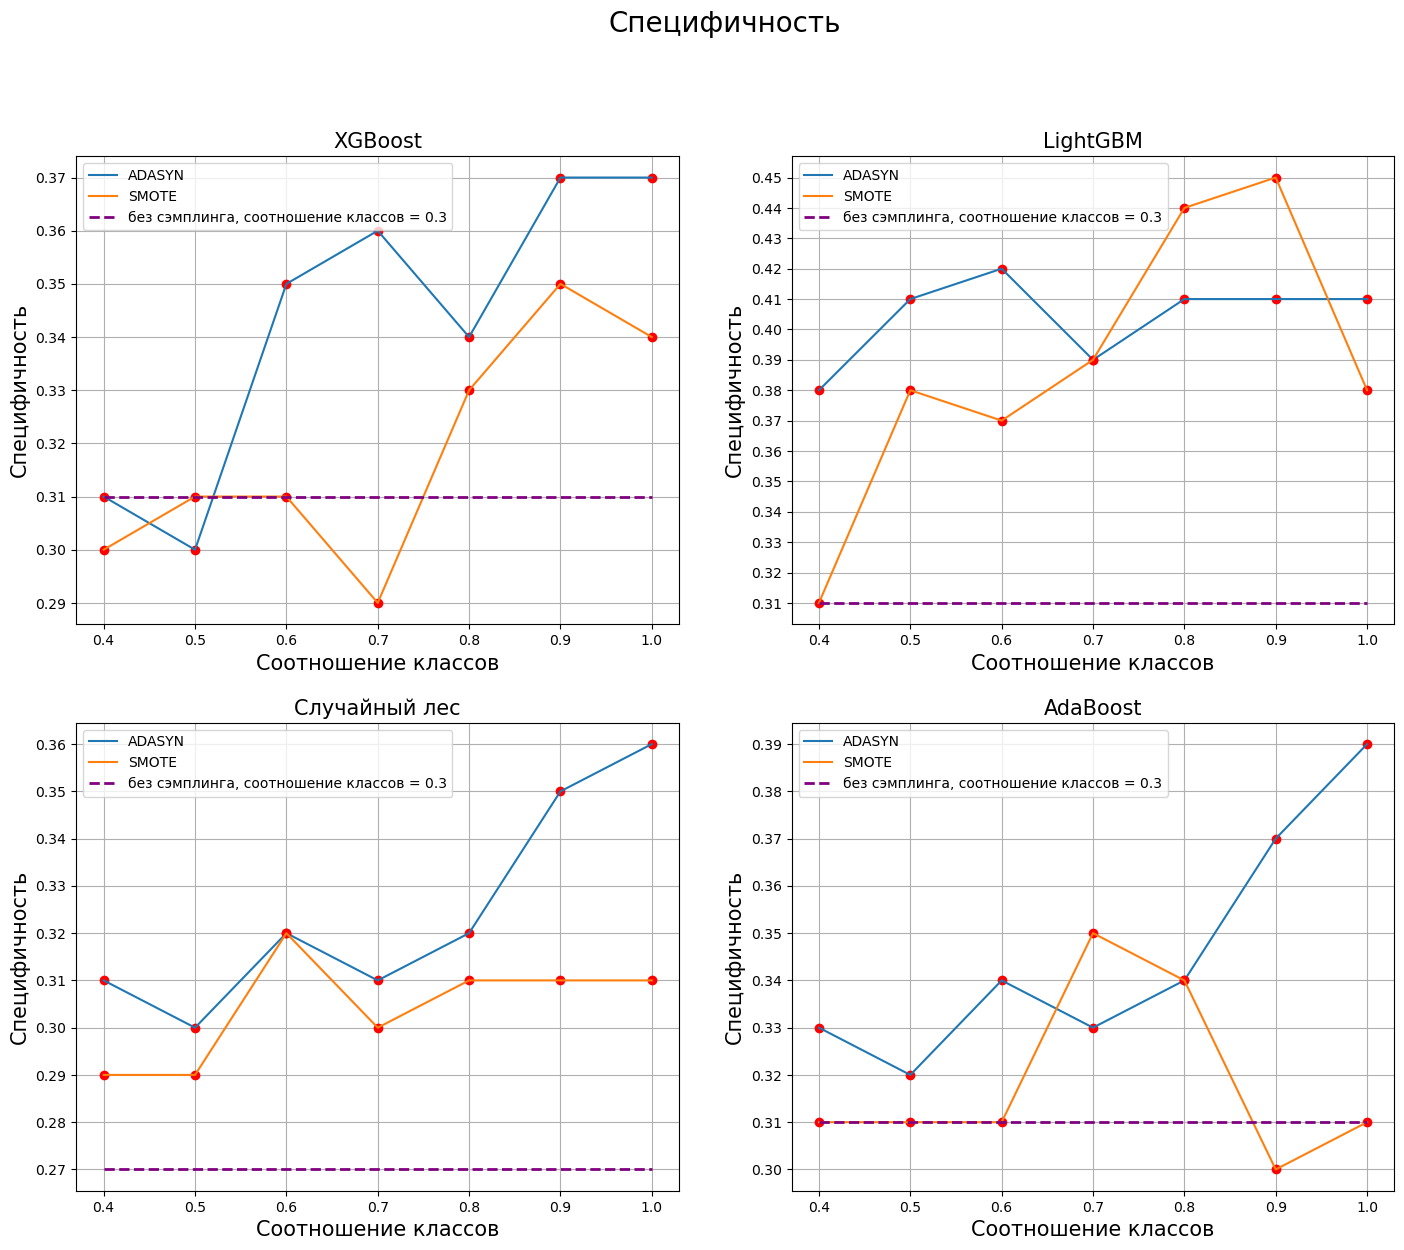

In [111]:
plot_res_for_metric(spec_cube, 'Специфичность')

## ROC_AUC

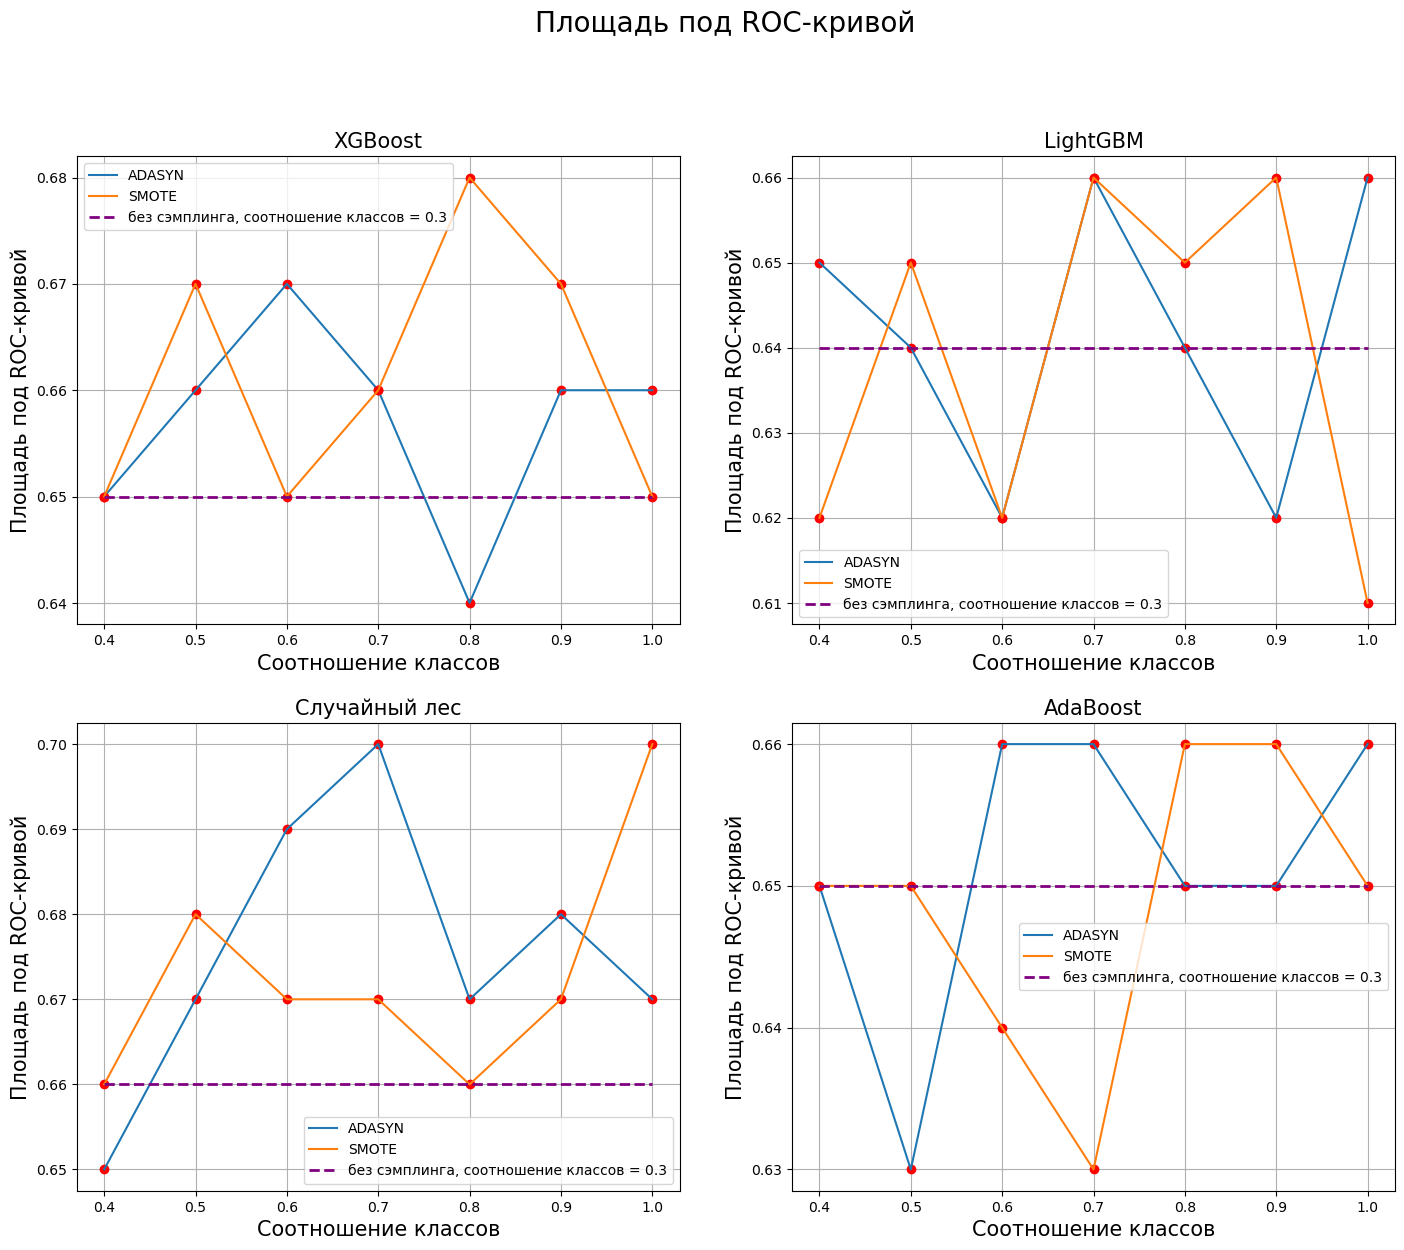

In [112]:
plot_res_for_metric(roc_auc_cube, 'Площадь под ROC-кривой')

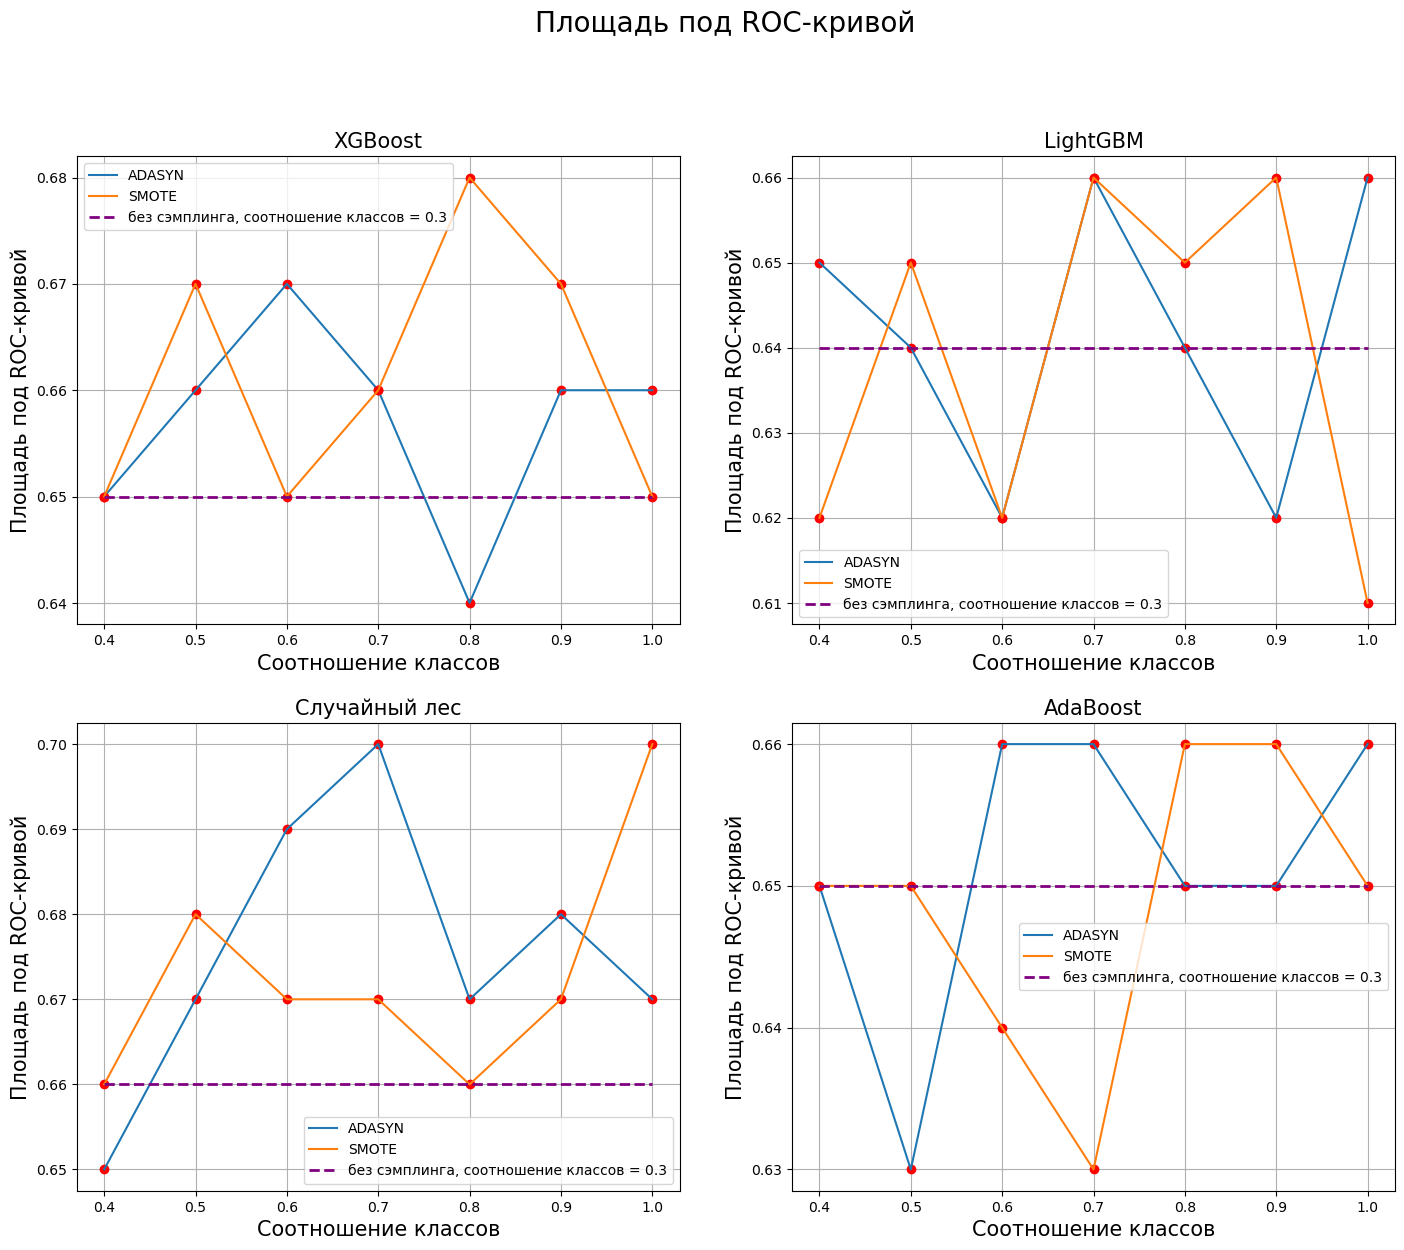

In [59]:
plot_res_for_metric(roc_auc_cube, 'Площадь под ROC-кривой')

## Sample charachteristics display

In [11]:
def plot_charachterisitcs(cube, quality):
    _, strategy_idx, ratio_idx = np.where(np.greater_equal(cube, quality))
    init_ratio = round(min(class_count) / max(class_count), 1)
    minority_ratio = np.arange(init_ratio + 0.1, 1.1, 0.1)
    strategies = ['без сэмплинга', 'ADASYN', 'SMOTE']
    ratio_dict = {}
    for i, idx in enumerate(ratio_idx):
        if idx in ratio_dict:
            ratio_dict[minority_ratio[idx]].add(strategies[strategy_idx[i]])
        else:
            ratio_dict[minority_ratio[idx]] = set([strategies[strategy_idx[i]]])
    sample_ratio = []
    for ratio in ratio_dict:
        for strategy in ratio_dict[ratio]:
            sample_ratio.append((samples_dict[f'{strategy}_{ratio}'], round(ratio, 1), strategy))
    sample_ratio.append((X_train, init_ratio, 'без сэмплинга'))
    fig, axs = plt.subplots(2, 2, figsize=(15, 13))
    fig.suptitle('Сравнение сэмплированных и исходной выборок', fontsize=20)
    fig.tight_layout(pad=5.0)
    cnt = Counter(le.inverse_transform(list(y_train)))
    features = ['ИМТ', 'Возраст, лет', 'Вес, кг', 'Наличие НУО']
    for i, feature in enumerate(features): 
        if feature == 'Наличие НУО':
            for sample, ratio, strategy in sorted(sample_ratio, key=lambda x: x[1], reverse=True):
                cnt_sampled = Counter(le.inverse_transform(list(y_train) + [1] * int(ratio*1945 - 626)))
                axs[i // 2, i % 2].bar(cnt_sampled.keys(), cnt_sampled.values(), width=0.3, label=f'Соотношение классов: {ratio}, {strategy}')
                axs[i // 2, i % 2].legend(loc='upper center')
        else:
            feature_data = []
            labels = []
            X_train_calc = X_train[X_train['ИМТ'] < 100]
            _, bins = np.histogram(X_train_calc[feature])
            for sample, ratio, strategy in sorted(sample_ratio, key=lambda x: x[1], reverse=True):
                sample_df = pd.DataFrame(sample, columns=feature_names)
                sample_df = sample_df[sample_df['ИМТ'] < 100]
                feature_data.append(sample_df[feature])
                labels.append(f'Соотношение классов: {ratio}, {strategy}')
            axs[i // 2, i % 2].hist(feature_data, rwidth=0.7, histtype='bar', bins=bins, label=labels)
            axs[i // 2, i % 2].set_ylabel('Число пациентов', fontsize=15)
            axs[i // 2, i % 2].legend(loc='upper right')
            axs[i // 2, i % 2].set_xticks(np.round(bins))
        axs[i // 2, i % 2].grid(which='both')
        axs[i // 2, i % 2].set_title(feature, fontsize=15)

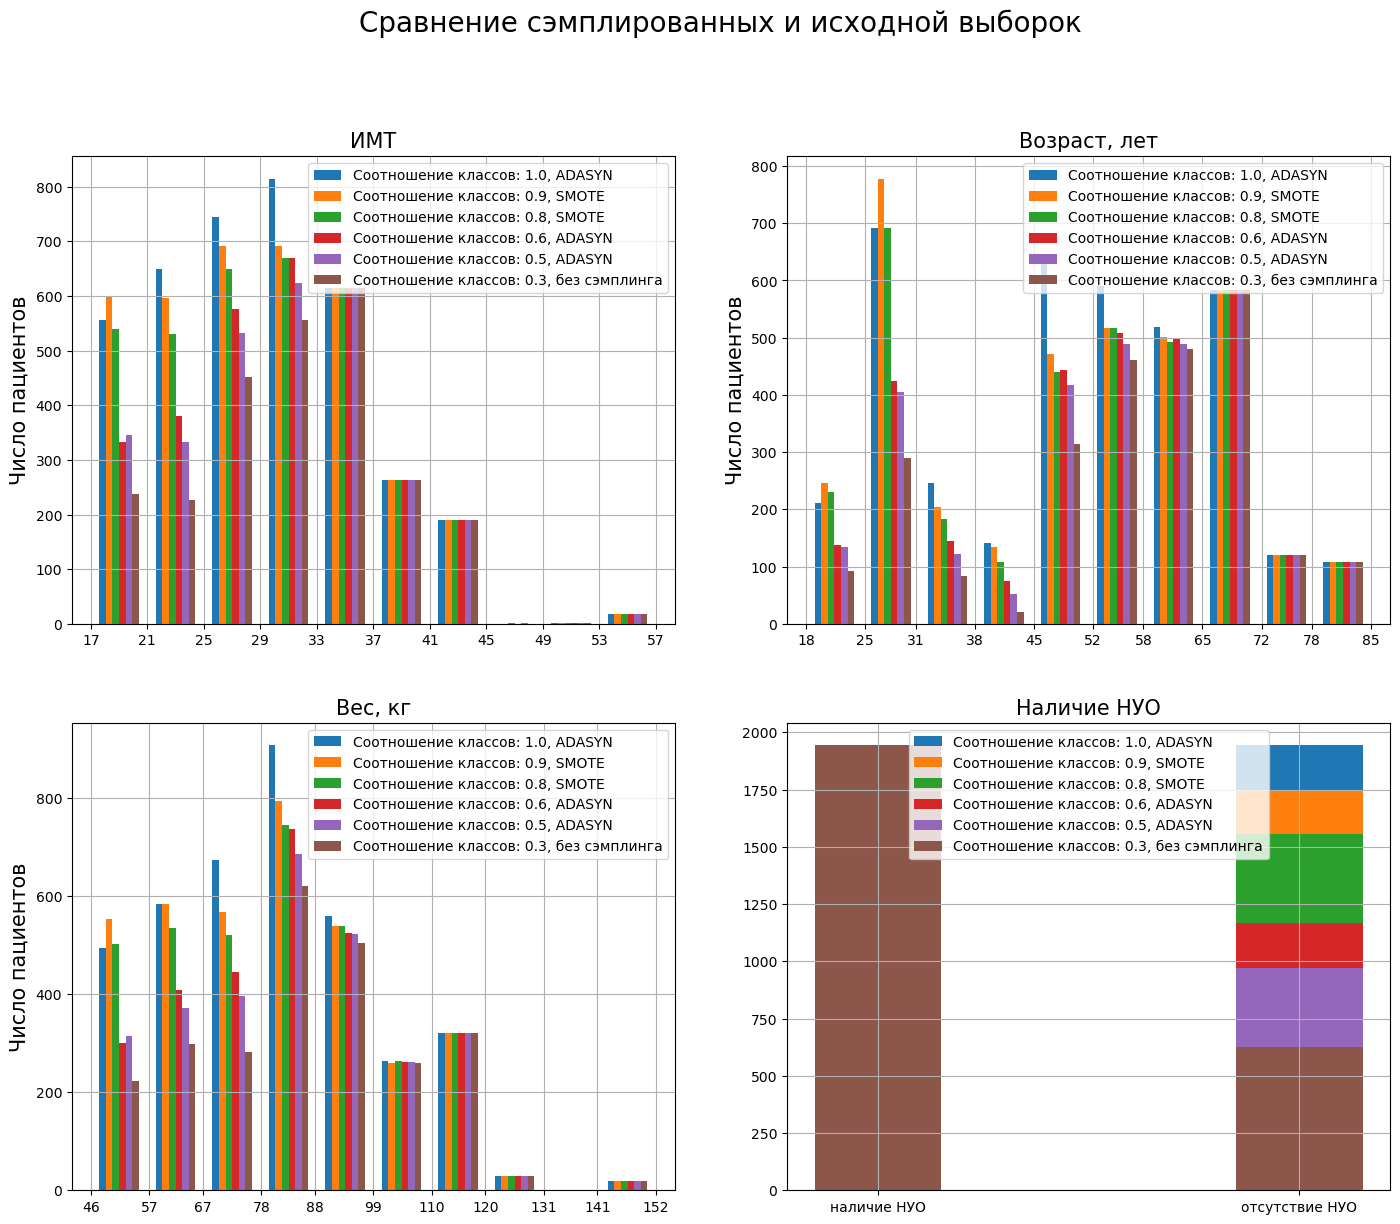

In [12]:
plot_charachterisitcs(sens_cube, 0.4)

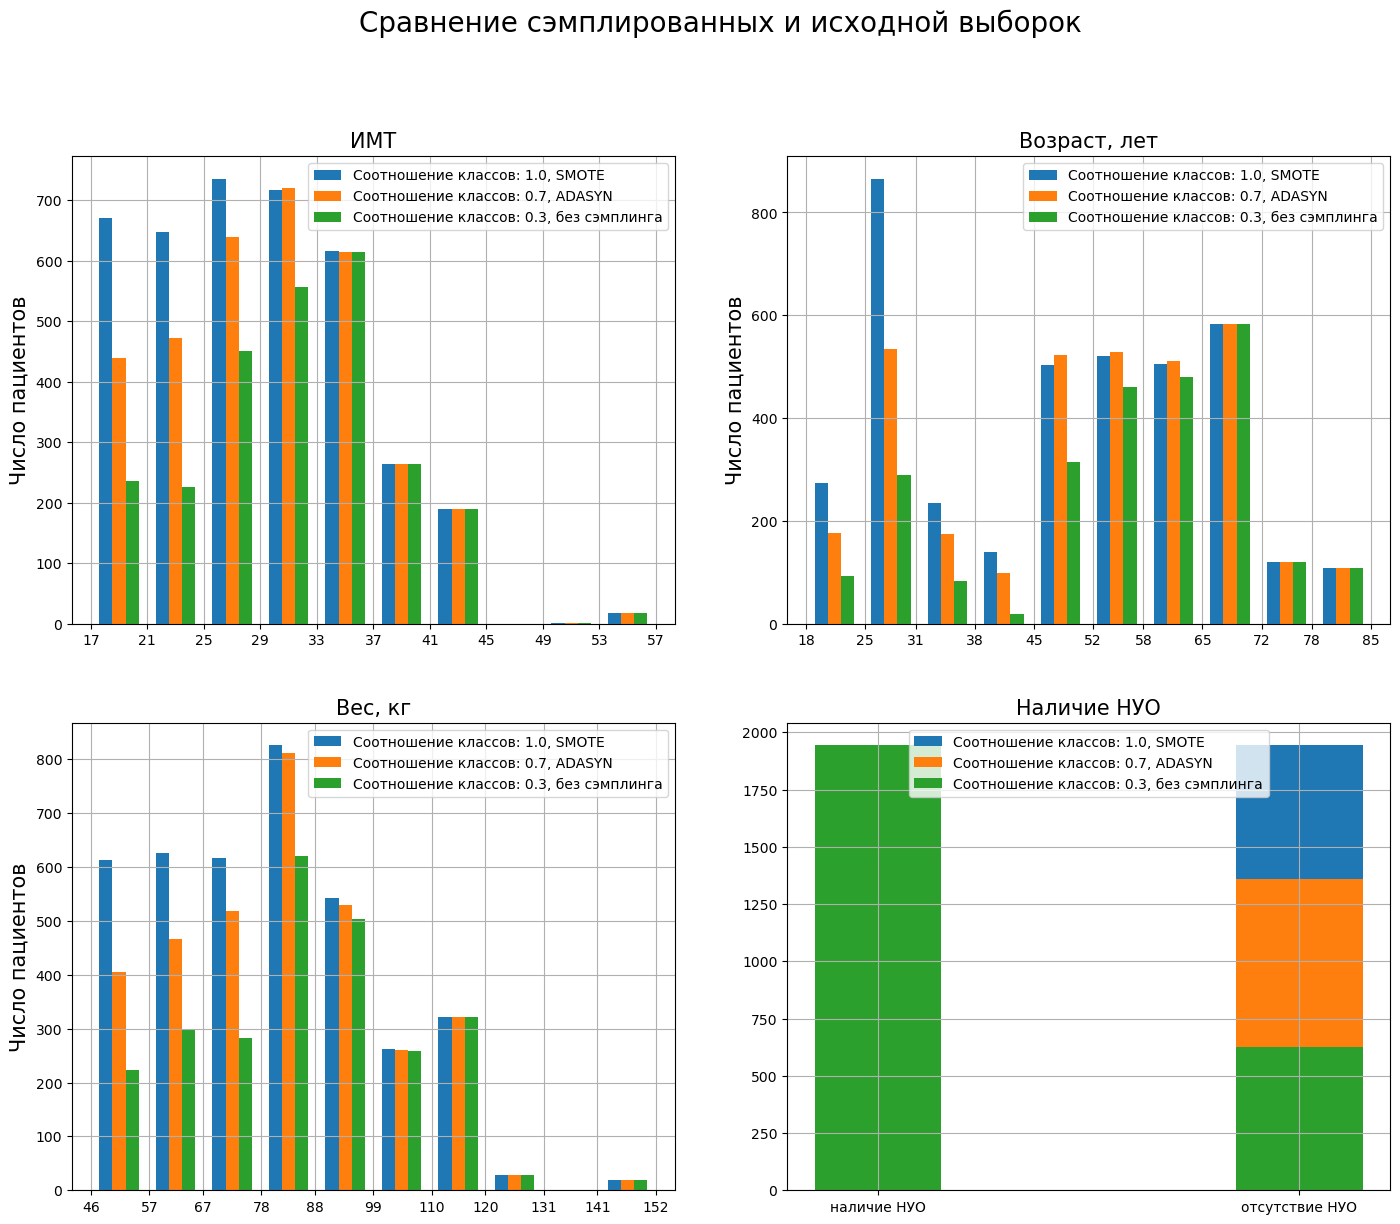

In [61]:
plot_charachterisitcs(roc_auc_cube, 0.7)

In [17]:
cnt = Counter(le.inverse_transform(list(y_train)))

In [18]:
cnt

Counter({'наличие НУО': 1945, 'отсутствие НУО': 626})

In [52]:
def get_difference_table(cube, quality):
    diff_dict = {}
    _, strategy_idx, ratio_idx = np.where(np.greater_equal(cube, quality))
    init_ratio = round(min(class_count) / max(class_count), 1)
    minority_ratio = np.arange(init_ratio + 0.1, 1.1, 0.1)
    strategies = ['без сэмплинга', 'ADASYN', 'SMOTE']
    ratio_dict = {}
    for i, idx in enumerate(ratio_idx):
        if idx in ratio_dict:
            ratio_dict[minority_ratio[idx]].add(strategies[strategy_idx[i]])
        else:
            ratio_dict[minority_ratio[idx]] = set([strategies[strategy_idx[i]]])
    sample_ratio = []
    for ratio in ratio_dict:
        for strategy in ratio_dict[ratio]:
            sample_ratio.append((samples_dict[f'{strategy}_{ratio}'], round(ratio, 1), strategy))
    cnt = Counter(le.inverse_transform(list(y_train)))
    features = ['ИМТ', 'Возраст, лет', 'Вес, кг', 'Наличие НУО']
    cols = []
    for feature in features:
        if feature == 'Наличие НУО':
            cnt = Counter(le.inverse_transform(list(y_train)))
            samples = ['Исходная']
            healthy_number = [cnt['отсутствие НУО']]
            for sample, ratio, strategy in sorted(sample_ratio, key=lambda x: x[1], reverse=True):
                cnt_sampled = Counter(le.inverse_transform(list(y_train) + [1] * int(ratio*1945 - 626)))
                healthy_number.append(cnt_sampled['отсутствие НУО'])
                samples.append(f'СК: {ratio}, {strategy}')
            diff_dict[f"Выборка"] = samples + [np.nan] * (9 - len(sample_ratio))
            cols.append('Выборка')
            diff_dict[f"Число пациентов без НУО"] = healthy_number + [np.nan] * (9 - len(sample_ratio))
            cols.append('Число пациентов без НУО')
        else:
            X_train_calc = X_train[X_train['ИМТ'] < 100]
            cnt_init, bins = np.histogram(X_train_calc[feature])
            intervals = []
            for i in range(len(bins) - 2):
                intervals.append(f"[{round(bins[i])}, {round(bins[i+1])})")
            else:
                intervals.append(f"[{round(bins[i + 1])}, {round(bins[i+2])}]")
            diff_dict[f"Интервалы: {feature}"] = intervals
            cols.append(f"Интервалы: {feature}")
            diff_dict[f"Исходное число пациентов: {feature}"] = cnt_init
            cols.append('ИЧП')
            for sample, ratio, strategy in sorted(sample_ratio, key=lambda x: x[1], reverse=True):
                sample_df = pd.DataFrame(sample, columns=feature_names)
                sample_df = sample_df[sample_df['ИМТ'] < 100]
                cnt_sampled, bins = np.histogram(sample_df[feature], bins=bins)
                diff_dict[f"ДЧП; СК: {ratio}, {strategy}, {feature}"] = cnt_sampled - cnt_init
                cols.append(f"ДЧП; СК: {ratio}, {strategy}")
    df = pd.DataFrame.from_dict(diff_dict).fillna('')
    df.columns = cols
    return df

In [60]:
get_difference_table(roc_auc_cube, 0.7).to_excel('results\\roc_auc.xlsx', index=False, header=True)